# How do star ratings work for stays?

In addition to written reviews, guests can submit an overall star rating and a set of category star ratings for their stay.

Hosts can view their star ratings on their Progress page, under Reviews. Hosts using professional hosting tools can find reviews and quality details on their Performance page, under Quality.

Guests can give ratings on:

- **Overall experience.** Overall, how was the stay?
- **Cleanliness.** Did guests feel that the space was clean and tidy?
- **Accuracy.** How accurately did the listing page represent the space? For example, guests should be able to find up-to-date info and photos in the listing description.
- **Value.** Did the guest feel that the listing provided good value for the price?
- **Communication.** How well did you communicate before and during the stay? Guests often care that their host responds quickly, reliably, and frequently to their messages and questions.
- **Check-in.** How smoothly did check-in go?
- **Location.** How did guests feel about the neighborhood? This may mean that there's an accurate description for proximity and access to transportation, shopping centers, city center, etc., and a description that includes special considerations, like noise, and family safety.
- **Amenities.** How did guests feel about the amenities that were available during their stay? Guests often care that all the amenities listed are available, working, and in good condition.

In each category, hosts are able to see how often they get 5 stars, how guests rated nearby hosts, and, in some cases, tips to help improve the listing.

The number of stars displayed at the top of a listing page is an aggregate of the primary scores guests have given for that listing. At the bottom of a listing page there's an aggregate for each category rating. A host needs to receive star ratings from at least 3 guests before their aggregate score appears.

## Our contribution

- Apply Bayesian Averaging in each type of rating because the data we use seems to have a broader spectrum of ratings from: 3-10
- Determine what type of rating contributes the most to predicting price
- Determine polarity in reviews
- Determine the connection between review's polarity and rating (WIP)

In [1]:
import pandas as pd
import datetime
from re import sub
import warnings

from sklearn import preprocessing
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

import numpy as np

warnings.filterwarnings("ignore")

import seaborn as sns
# import matplotlib as plt
import matplotlib.pyplot as plt

from yellowbrick.features import rank2d
from yellowbrick.classifier import confusion_matrix
from yellowbrick.classifier import classification_report
from yellowbrick.regressor import prediction_error, ResidualsPlot

# Change pandas viewing options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Importing Data

In [2]:
df_listings = pd.read_csv("../../data/new-york-city-airbnb-open-data/listings.csv")
df_cal = pd.read_csv("../../data/new-york-city-airbnb-open-data/calendar.csv")
df_reviews_w_polarity = pd.read_csv('output/reviews_with_sentiment_and_lang.csv')

In [3]:
cols_to_keep = ['id','host_acceptance_rate','number_of_reviews',
                'number_of_reviews_ltm','review_scores_rating', 
                'review_scores_accuracy','review_scores_cleanliness', 
                'review_scores_checkin', 'review_scores_communication',
                'review_scores_location', 'review_scores_value','price']

df_listings = df_listings[cols_to_keep]

This tutorial is based on this Stackoverflow entry https://stackoverflow.com/questions/54357300/bayesian-averaging-in-a-dataframe

## Applying Bayesian Averaging to Normalize rating columns

In [4]:
# number_of_reviews == v
# calculating the mean and median of "number_of_reviews"
m = np.mean(df_listings['number_of_reviews'])
md = np.median(df_listings['number_of_reviews'])

In [5]:
# print(m,md)

In [6]:
# calculating w
df_listings['w'] = df_listings['number_of_reviews']/(df_listings['number_of_reviews'] + m)

In [7]:
# df_listings.head()

**Normalizing: review_score_value**

In [8]:
df_1 = df_listings[['id','number_of_reviews','review_scores_value']]

# renaming column
df_1.rename(columns={"id": "listing_id"}, inplace=True)

temp_rsv = df_1.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_value': lambda x: x.mean(skipna=False)})

# review_scores_value_x == R
df_1 = pd.merge(left=df_1, right=temp_rsv, 
                       how='left', on='listing_id')

# average of review_scores_value column
C = df_1['review_scores_value_x'].mean()

df_1['review_score_value_norm'] = df_listings['w']*df_1['review_scores_value_x'] + (1 - df_listings['w'])*C

df_1 = df_1.drop(['number_of_reviews','review_scores_value_x', 'review_scores_value_y'], axis=1)

**Normalizing: review_scores_location**

In [9]:
df_2 = df_listings[['id','number_of_reviews','review_scores_location']]

# renaming column
df_2.rename(columns={"id": "listing_id"}, inplace=True)

temp_rsl = df_2.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_location': lambda x: x.mean(skipna=False)})

# review_scores_location_x == R
df_2 = pd.merge(left=df_2, right=temp_rsl, 
                       how='left', on='listing_id')

# average of review_scores_location column
C = df_2['review_scores_location_x'].mean()

df_2['review_location_norm'] = df_listings['w']*df_2['review_scores_location_x'] + (1 - df_listings['w'])*C

df_2 = df_2.drop(['listing_id','number_of_reviews','review_scores_location_x', 'review_scores_location_y'], axis=1)

**Normalizing: review_scores_communication**

In [10]:
df_3 = df_listings[['id','number_of_reviews','review_scores_communication']]

# renaming column
df_3.rename(columns={"id": "listing_id"}, inplace=True)

temp_rsc = df_3.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_communication': lambda x: x.mean(skipna=False)})

# review_scores_communication_x == R
df_3 = pd.merge(left=df_3, right=temp_rsc, 
                       how='left', on='listing_id')

# average of review_scores_communication column
C = df_3['review_scores_communication_x'].mean()

df_3['review_scores_comm_norm'] = df_listings['w']*df_3['review_scores_communication_x'] + (1 - df_listings['w'])*C

df_3 = df_3.drop(['listing_id','number_of_reviews','review_scores_communication_x', 'review_scores_communication_y'], axis=1)

**Normalizing: review_scores_checkin**

In [11]:
df_4 = df_listings[['id','number_of_reviews','review_scores_checkin']]

# renaming column
df_4.rename(columns={"id": "listing_id"}, inplace=True)

temp_rsck = df_4.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_checkin': lambda x: x.mean(skipna=False)})

# review_scores_checkin_x == R
df_4 = pd.merge(left=df_4, right=temp_rsck, 
                       how='left', on='listing_id')

# average of review_scores_checkin column
C = df_4['review_scores_checkin_x'].mean()

df_4['review_scores_checkin_norm'] = df_listings['w']*df_4['review_scores_checkin_x'] + (1 - df_listings['w'])*C

df_4 = df_4.drop(['listing_id','number_of_reviews','review_scores_checkin_x', 'review_scores_checkin_y'], axis=1)

**Normalizing: review_scores_cleanliness**

In [12]:
df_5 = df_listings[['id','number_of_reviews','review_scores_cleanliness']]

# renaming column
df_5.rename(columns={"id": "listing_id"}, inplace=True)

temp_rscl = df_5.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_cleanliness': lambda x: x.mean(skipna=False)})

# review_scores_cleanliness_x == R
df_5 = pd.merge(left=df_5, right=temp_rscl, 
                       how='left', on='listing_id')

# average of review_scores_cleanliness column
C = df_5['review_scores_cleanliness_x'].mean()

df_5['review_scores_cleanliness_norm'] = df_listings['w']*df_5['review_scores_cleanliness_x'] + (1 - df_listings['w'])*C

df_5 = df_5.drop(['listing_id','number_of_reviews','review_scores_cleanliness_x', 'review_scores_cleanliness_y'], axis=1)

**Normalizing: review_scores_accuracy**

In [13]:
df_6 = df_listings[['id','number_of_reviews','review_scores_accuracy']]

# renaming column
df_6.rename(columns={"id": "listing_id"}, inplace=True)

temp_rsa = df_6.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_accuracy': lambda x: x.mean(skipna=False)})

# review_scores_accuracy_x == R
df_6 = pd.merge(left=df_6, right=temp_rsa, 
                       how='left', on='listing_id')

# average of review_scores_accuracy column
C = df_6['review_scores_accuracy_x'].mean()

df_6['review_scores_accuracy_norm'] = df_listings['w']*df_6['review_scores_accuracy_x'] + (1 - df_listings['w'])*C

df_6 = df_6.drop(['listing_id','number_of_reviews','review_scores_accuracy_x', 'review_scores_accuracy_y'], axis=1)

**Normalizing: review_scores_rating**

In [14]:
df_7 = df_listings[['id','number_of_reviews','review_scores_rating']]

# renaming column
df_7.rename(columns={"id": "listing_id"}, inplace=True)

temp_rsr = df_7.groupby('listing_id', 
                        as_index=False
                       ).agg({'review_scores_rating': lambda x: x.mean(skipna=False)})

# review_scores_rating_x == R
df_7 = pd.merge(left=df_7, right=temp_rsr, 
                       how='left', on='listing_id')

# average of review_scores_rating column
C = df_7['review_scores_rating_x'].mean()

df_7['review_scores_rating_norm'] = df_listings['w']*df_7['review_scores_rating_x'] + (1 - df_listings['w'])*C

df_7 = df_7.drop(['listing_id','number_of_reviews','review_scores_rating_x', 'review_scores_rating_y'], axis=1)

## Setting our features up

In [15]:
dfs = pd.concat([df_1, df_2, df_3, df_4,df_5, df_6, df_7], axis=1)

## Cleaning and setting up the target variable

In [16]:
# renaming id column
df_listings.rename(columns={"id": "listing_id"}, inplace=True)

# slicing dataframe to contain price and listing_id
df_price = df_listings.loc[:,['listing_id','price']]

# formatting price to float values
df_price.price = [float(sub(r'[^\d.]', '', r['price'])) for i, r in df_listings.iterrows()]

## Merging DataFrames to Drop Null Values

In [17]:
# merging colums wit normalized ratings and the price column
df_temp = pd.merge(left=dfs, right=df_price, on='listing_id')

# remove null values
df_temp = df_temp.dropna()

df_temp = df_temp.set_index('listing_id')

## Defining the target and the features

In [18]:
# target
y = df_temp.price

# features
X = df_temp.loc[:, df_temp.columns != 'price']

## Splitting trainin and testing

In [19]:
Xr_train, Xr_test, yr_train, yr_test = tts(X, y, test_size=0.2)

## Linear Regression

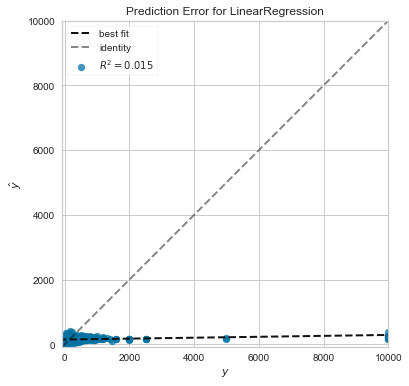

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(Xr_train, yr_train)

_, ax = plt.subplots(figsize=(9,6))
_ = prediction_error(model, Xr_test, yr_test, is_fitted=True, ax=ax)

## Random Forest

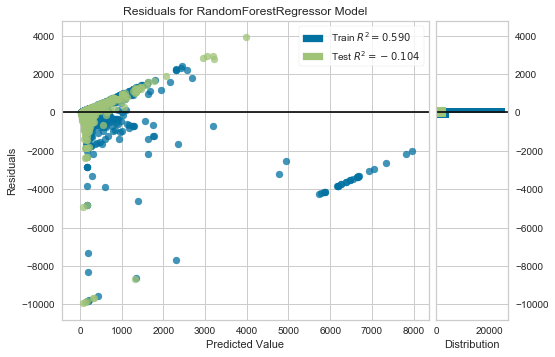

In [21]:
model = RandomForestRegressor()
oz = ResidualsPlot(model)

oz.fit(Xr_train, yr_train)
oz.score(Xr_test, yr_test)
_ = oz.show()